$ \textbf{Aluna:}$ Alessandra da Silva Dias Malizia   
$ \textbf{Data:}$ 11/06/2025

# Lista Prática 2

In [143]:
import numpy as np
import math
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import breakvar_heteroskedasticity_test

# Preparação dos dados

In [3]:
data_base = pd.read_csv('C:/Users/aless/Desktop/Codes/masters/Modelos estruturais/dados_precipitacao.csv')
data_base.dtypes

id_estacao             object
estacao                object
data_fundacao          object
ano                     int64
mes                     int64
precipitacao_total    float64
dtype: object

In [4]:
data_base['data'] = pd.to_datetime(data_base.apply(lambda row: '{}-{:02}-01'.format(row.ano, row.mes), axis=1))
data = data_base.pivot_table(index='data', columns='estacao', values='precipitacao_total')

In [5]:
estacoes = data.apply(lambda col: col.dropna().index[0]).sort_values().head(5).index
data.apply(lambda col: col.dropna().index[0]).sort_values().head(10)

estacao
Manaus                         2000-05-01
Brasilia                       2000-05-01
Seropedica-Ecologia Agricola   2000-05-01
Porto Alegre                   2000-09-01
Salvador                       2000-10-01
Morrinhos                      2001-05-01
Goiania                        2001-05-01
Bauru                          2001-08-01
Campo Grande                   2001-09-01
Tres Lagoas                    2001-09-01
dtype: datetime64[ns]

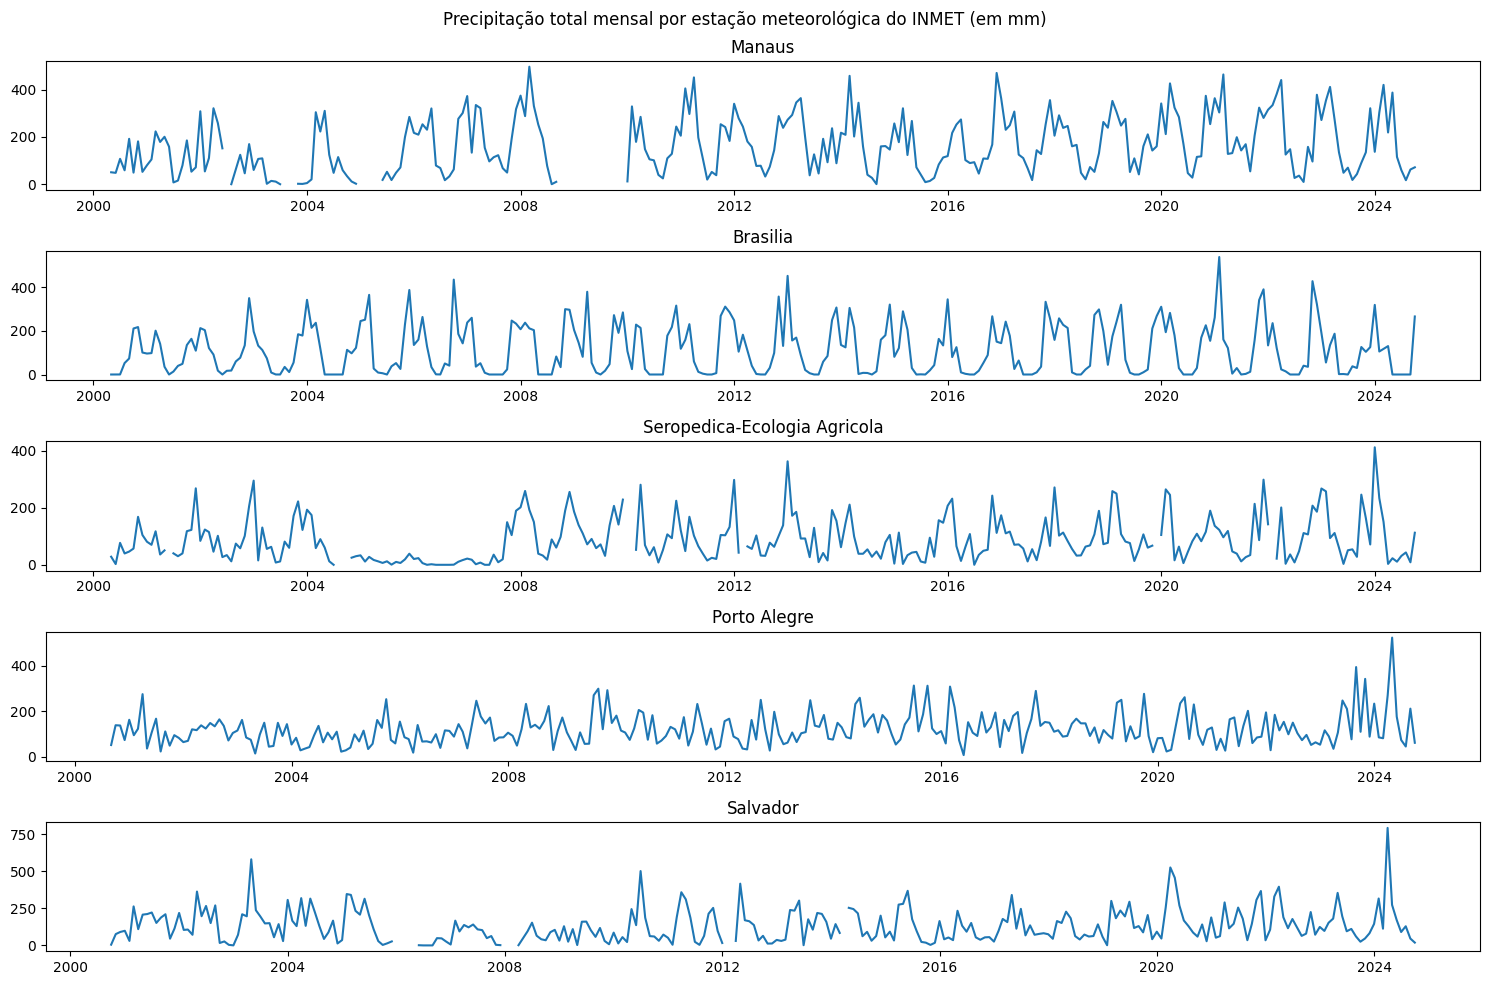

In [6]:
fig, ax = plt.subplots(5, figsize=(15,10))

for i in range(5):
    ax[i].plot(data[estacoes].iloc[:,i])
    ax[i].set_title(estacoes[i])
    # ax[i].grid()


fig.suptitle('Precipitação total mensal por estação meteorológica do INMET (em mm)')
fig.tight_layout()
plt.show()

In [7]:
series = data[['Brasilia']]

In [10]:
series.to_csv('C:\\Users\\aless\\Desktop\\Codes\\masters\\Modelos estruturais\\dados_precipitacao_bsb.csv', index=True)

# Questão 1

## a)
- Gráfico da série temporal
- FAC
- FAC da 1 diferença
- FAC da 1 diferença da diferença sazonal

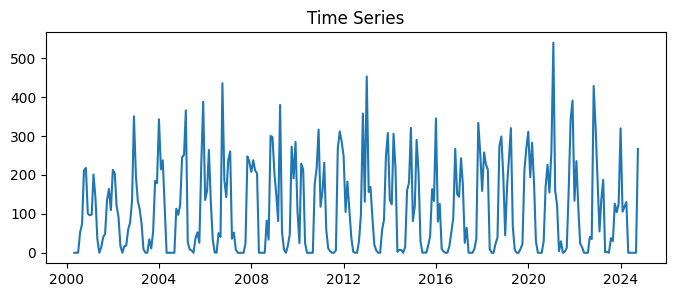

In [60]:
fig, ax = plt.subplots(figsize=(8,3))

ax.plot(series)
ax.set_title('Time Series')
plt.show()

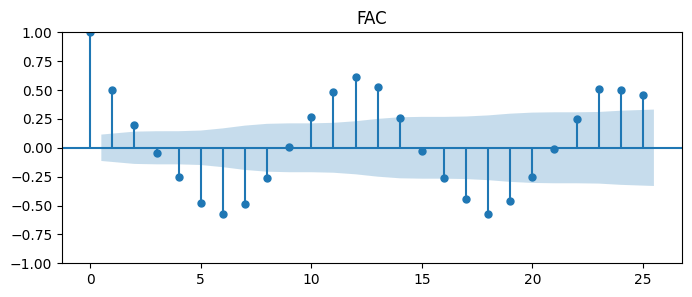

In [63]:
fig, ax = plt.subplots(figsize=(8,3))

plot_acf(series, ax=ax, title='FAC')

plt.show()

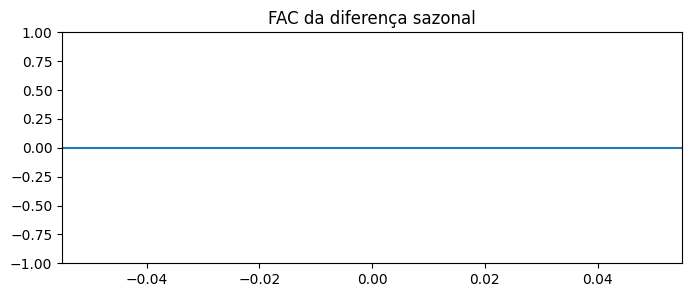

In [72]:
fig, ax = plt.subplots(figsize=(8,3))

plot_acf(series.diff(12), ax=ax, title='FAC da diferença sazonal')

plt.show()

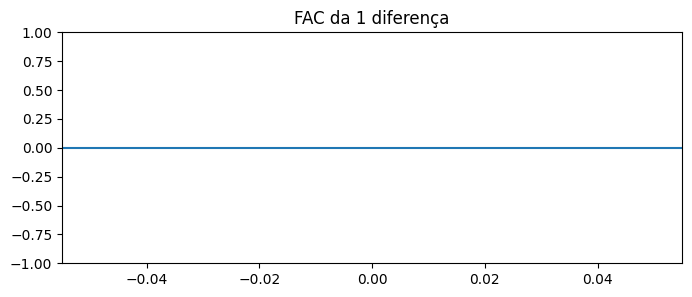

In [64]:
fig, ax = plt.subplots(figsize=(8,3))

plot_acf(series.diff(), ax=ax, title='FAC da 1 diferença')

plt.show()

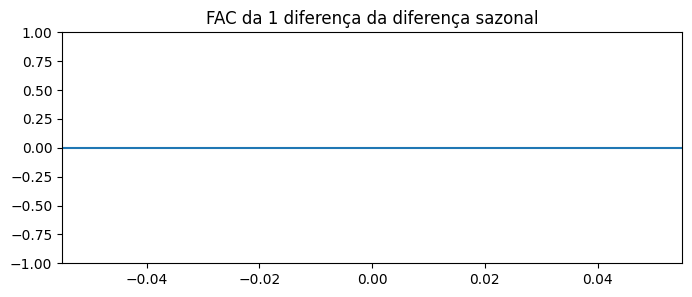

In [73]:
fig, ax = plt.subplots(figsize=(8,3))

plot_acf(series.diff(12).diff(), ax=ax, title='FAC da 1 diferença da diferença sazonal')

plt.show()

## b)
- Boxplot da série original
- Boxplot da 1 diferença

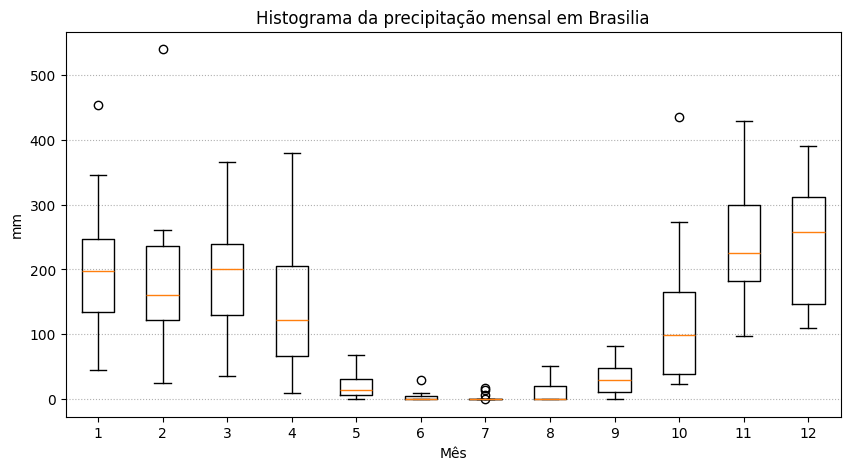

In [80]:
fig, ax = plt.subplots(figsize=(10,5))
plot_data = (series
    .pivot_table(columns=series.index.month, index=series.index.year, values='Brasilia')
    .dropna()
)
ax.boxplot(plot_data)
ax.set_ylabel('mm')
ax.set_xlabel('Mês')
ax.grid(axis='y', linestyle=':')
ax.set_title('Histograma da precipitação mensal em Brasilia')
plt.show()

## c) Teste de sazonalidade

In [93]:
acorr_ljungbox(series['Brasilia'], lags=[15])

,lb_stat,lb_pvalue
15,682.041703,1.246815e-135


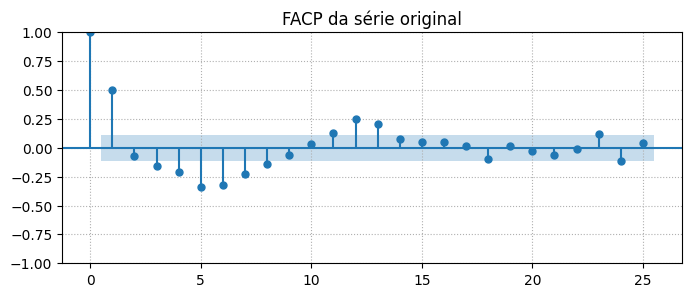

In [94]:
fig, ax = plt.subplots(figsize=(8,3))

plot_pacf(series, ax=ax, title='FACP da série original')
ax.grid(axis='both', linestyle=':')
plt.show()

# 1) Sazonalidade com trigonométricos

## d) Estimação do modelo

In [62]:
def KalmanFilter(Y, T, Z, Q, H, C, D, x0, P0):
    
    n = len(Y)
    p = Y.shape[1]
    m = T.shape[0]

    # inicialização dos arrays
    x_hat = np.ones((n, m, 1))
    x_hat_minus = np.ones((n, m, 1))
    P_minus_t = np.zeros((n, m, m))
    P = np.zeros((n, m, m))
    F_t = np.zeros((n, p, p))
    v_t = np.zeros((n, p, 1))
    
    # valores inicias
    x_hat[0] = x0
    x_hat_minus[0] = x0
    P[0] = P0
    P_minus_t[0] = P0
    F_t[0] = H
    log_likelihood = -n/2 * np.log(2 * np.pi)

    # Kalman filter
    for iteration in range(1, n):
        # previsão
        x_hat_minus[iteration] = T @ x_hat[iteration - 1] + C        
        P_minus = np.array(T @ P[iteration - 1] @ T.T + Q)
        P_minus = P_minus.reshape((m, m))
        P_minus_t[iteration] = P_minus

        # inovação e variança da inovação
        eta_t = Y[iteration].reshape(p, 1) - Z[iteration] @ x_hat_minus[iteration] - D
        v_t[iteration] = eta_t
        F_t[iteration] = Z[iteration] @ P_minus_t[iteration] @ Z[iteration].T + H
        covariance_determinant = np.linalg.det(F_t[iteration])
        if abs(covariance_determinant) == 0 or str(covariance_determinant).lower() == "nan":
            return -1e10, x_hat_minus, x_hat, P, v_t
            
        # log-likelihood
        log_like = np.log(np.linalg.det(F_t[iteration])) + eta_t.T @ np.linalg.inv(F_t[iteration]) @ eta_t
        log_likelihood -= 0.5 * log_like[0][0]

        # atualização
        Kalman_gain = P_minus_t[iteration] @ Z[iteration].T @ np.linalg.inv(F_t[iteration])
        x_hat[iteration] = x_hat_minus[iteration] + Kalman_gain @ eta_t
        P[iteration] = P_minus_t[iteration] - Kalman_gain @ Z[iteration] @ P_minus_t[iteration]

    return log_likelihood, x_hat_minus, x_hat, P, v_t

In [108]:
n_harm = 6
N = series.shape[0]
m = 2 + 2*n_harm - 1 # mu, beta, gamma 1 a n, gamma* 1 a n-1

Z = np.zeros((1, m))
Z[0, 0] = 1  # mu
Z[0, 2::2] = 1  # pega todas as gammas e ignora os gammas*
Z_t = np.tile(Z, (N, 1, 1)) # expande Z no tempo com Z fixo

T = np.zeros((m, m))
T[0, 0] = 1   # mu_t = mu_{t-1} + beta_{t-1}
T[0, 1] = 1
T[1, 1] = 1   # beta_t = beta_{t-1}

# blocos sazonais C_j (2x2)
for j in range(n_harm - 1):
    angle = np.pi * (j + 1) / 6
    Cj = np.array([
        [np.cos(angle), np.sin(angle)],
        [-np.sin(angle), np.cos(angle)]
    ])
    row = 2 + 2 * j
    T[row:row+2, row:row+2] = Cj
T[-1, -1] = -1 # Último harmônico

C = np.zeros((m, 1))
D = np.zeros((1, 1))

sigma_eps = 0.5
H = np.array([[sigma_eps]])

Q = np.zeros((m, m))
sigma_eta = 0.01
sigma_zeta = 0.001
sigma_w = 0.1
Q[0, 0] = sigma_eta
Q[1, 1] = sigma_zeta
Q[2:, 2:] = sigma_w * np.eye(m - 2)

x0 = np.zeros((m, 1))
P0 = np.eye(m) * 10

Y = series.values
log_likelihood, x_hat_minus, x_hat, P, v_t = KalmanFilter(Y, T, Z_t, Q, H, C, D, x0, P0)
print(f"Log Likelihood is {log_likelihood}")

del Y, T, Z_t, Q, H, C, D, x0, P0

Log Likelihood is -159715.39475252235


In [110]:
# for i in range(1,7):
#     cols += 'sazonalidade #datetime(2025,i,1).strftime('%b').lower()

resultados = {
    'inovacao': pd.Series(index=series.index, data=v_t.reshape(-1), name='inovacao'),
    'predicted': pd.DataFrame(
        index=series.index, 
        data={
            'tendencia':x_hat_minus[:,0,:].reshape(-1), 
            'inclinacao':x_hat_minus[:,1,:].reshape(-1)
        }),
    'filtered': pd.DataFrame(
        index=series.index, 
        data={
            'tendencia':x_hat[:,0,:].reshape(-1), 
            'inclinacao':x_hat[:,1,:].reshape(-1)
        })
}

In [31]:
print(f"Log Likelihood is {log_likelihood}")

Log Likelihood is -159715.39475252238


## e) Estimativas das variâncias [TODO]

## f) Inovações

In [135]:
# inovações padronizadas
inovacoes = resultados['inovacao']
inovacoes = inovacoes.sub(inovacoes.mean()).div(inovacoes.std())

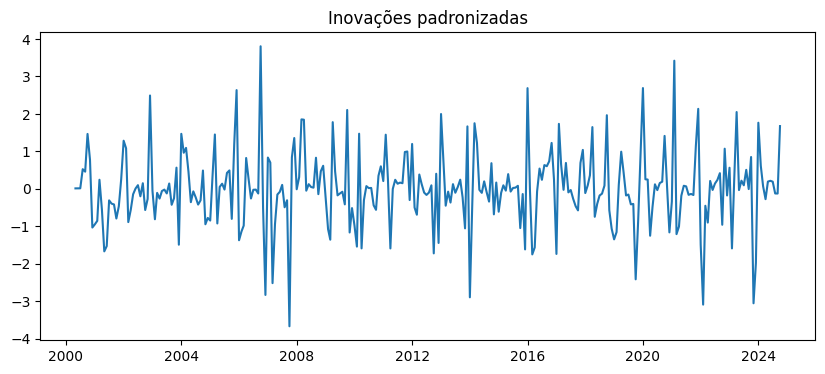

In [137]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(inovacoes)
ax.set_title('Inovações padronizadas')
plt.show()

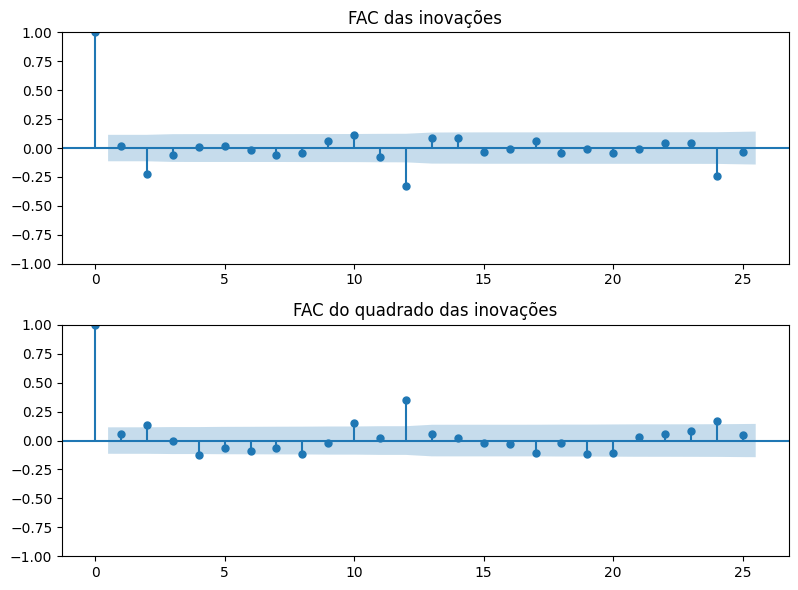

In [138]:
fig, ax = plt.subplots(2, figsize=(8,6))
plot_acf(inovacoes, ax=ax[0], title='FAC das inovações')
plot_acf(inovacoes.pow(2), ax=ax[1], title='FAC do quadrado das inovações')
fig.tight_layout()
plt.show()

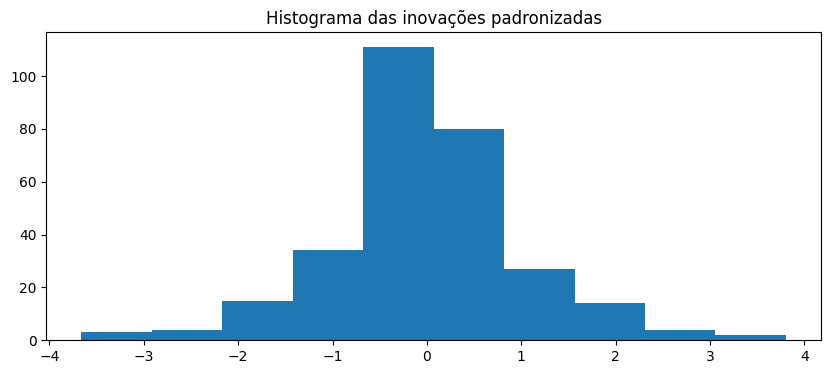

In [139]:
fig, ax = plt.subplots(figsize=(10,4))
ax.hist(inovacoes)
ax.set_title('Histograma das inovações padronizadas')
plt.show()

In [144]:
df_diagnostics = pd.DataFrame(columns=['Teste','Resultado'])

# coeficientes de assimetria e curtose
df_diagnostics.loc[df_diagnostics.shape[0]] = ['Assimetria', 'Coeficiente: {:.2f}'.format(inovacoes.skew())]
df_diagnostics.loc[df_diagnostics.shape[0]] = ['Curtose', 'Coeficiente: {:.2f}'.format(inovacoes.kurtosis()+3)]

# teste de jarque-bera
jb_result = jarque_bera(inovacoes)
df_diagnostics.loc[df_diagnostics.shape[0]] = ['Jarque-Bera', 'Estatística: {:.1f}, p-valor: {:.2f}'.format(jb_result[0], jb_result[1])]

# teste H
H_result = breakvar_heteroskedasticity_test(inovacoes, subset_length=1/3)
df_diagnostics.loc[df_diagnostics.shape[0]] = ['Teste H', 'Estatística: {:.1f}, p-valor: {:.2f}'.format(H_result[0], H_result[1])]

df_diagnostics.set_index('Teste')

,Resultado
Teste,
Assimetria,Coeficiente: 0.08
Curtose,Coeficiente: 5.14
Jarque-Bera,"Estatística: 53.2, p-valor: 0.00"
Teste H,"Estatística: 1.0, p-valor: 0.92"


## g) Gráfico das componentes

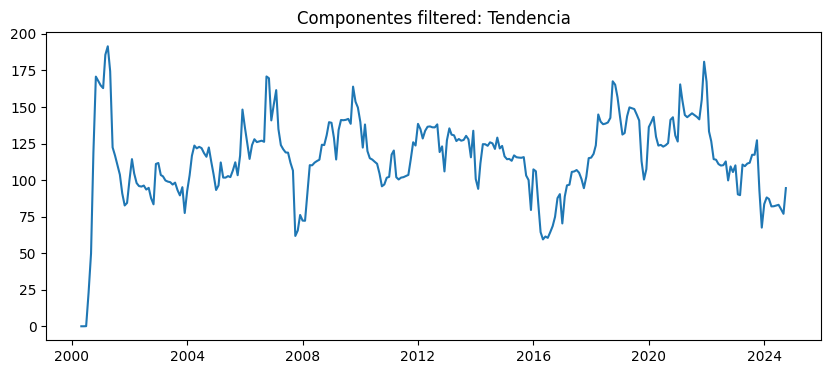

In [118]:
fig, ax = plt.subplots(figsize=(10,4))

mod = 'filtered'
var = 'tendencia'
ax.plot(resultados[mod][var])
ax.set_title('Componentes {}: {}'.format(mod, var.capitalize()))

# fig.suptitle('Precipitação total mensal por estação meteorológica do INMET (em mm)')
# fig.tight_layout()
plt.show()

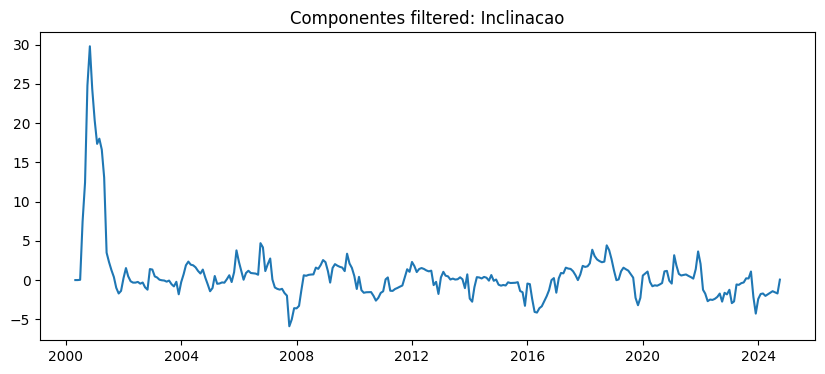

In [119]:
fig, ax = plt.subplots(figsize=(10,4))

mod = 'filtered'
var = 'inclinacao'
ax.plot(resultados[mod][var])
ax.set_title('Componentes {}: {}'.format(mod, var.capitalize()))

# fig.suptitle('Precipitação total mensal por estação meteorológica do INMET (em mm)')
# fig.tight_layout()
plt.show()

## h) Gráfico do efeito sazonal [TODO]

# 2) Sazonalidade com dummies

$$
\begin{align*}
y_t &= \mu_t + \gamma_t + \varepsilon_t \\
\mu_t &= \mu_{t-1} + \beta_{t-1} + \eta_t \\
\beta_t &= \beta_{t-1} + \zeta_t \\
\gamma_t &= D_t^\top S_t \\
S_t &= S_{t-1} + \omega_t
\end{align*}
$$


$$
\begin{align*}
y_t &= Z_t \alpha_t + \varepsilon_t, \quad \varepsilon_t \sim \mathcal{N}(0, H) \\
\alpha_t &= T \alpha_{t-1} + R \eta_t, \quad \eta_t \sim \mathcal{N}(0, Q)
\end{align*}
$$

$$
\alpha_t =
\begin{bmatrix}
\mu_t \\
\beta_t \\
S_t
\end{bmatrix}
\in \mathbb{R}^{14}
$$

In [149]:
n = series.shape[0]
m = 14 # mu, beta, D1 a D12
s = 12

Z = np.zeros((n, 1, m))
for t in range(n):
    month = series.index[t].month
    Z[t, 0, 0] = 1  # mu_t
    Z[t, 0, 2 + (month - 1)] = 1  # Dummies sazonais

T = np.eye(14)
T[0, 1] = 1  # mu_t = mu_{t-1} + beta_{t-1}

C = np.zeros((m, 1))
D = np.zeros((1, 1))

sigma_eps = 0.5
H = np.array([[sigma_eps]])

sigma_eta = 0.01
sigma_zeta = 0.001
sigma_omega = 0.1

Q = np.zeros((m, m))
Q[0, 0] = sigma_eta
Q[1, 1] = sigma_zeta
I, i = np.eye(s), np.ones((s, 1))
Sigma_star = sigma_omega * (I - (1/s) * i @ i.T)
Q[2:, 2:] = Sigma_star

x0 = np.zeros((m, 1))
P0 = np.eye(m) * 10

Y = series.values
log_likelihood, x_hat_minus, x_hat, P, v_t = KalmanFilter(Y, T, Z, Q, H, C, D, x0, P0)
print(f"Log Likelihood is {log_likelihood}")

# del Y, T, Z, Q, H, C, D, x0, P0

Log Likelihood is -563273.1493217439


In [157]:
resultados = {
    'inovacao': pd.Series(index=series.index, data=v_t.reshape(-1), name='inovacao'),
    'predicted': pd.DataFrame(
        index=series.index, 
        data={
            'tendencia':x_hat_minus[:,0,:].reshape(-1), 
            'inclinacao':x_hat_minus[:,1,:].reshape(-1)
        }),
    'filtered': pd.DataFrame(
        index=series.index, 
        data={
            'tendencia':x_hat[:,0,:].reshape(-1), 
            'inclinacao':x_hat[:,1,:].reshape(-1)
        })
}

In [158]:
for i in range(1,s+1):
    col = 'sazonalidade_' + datetime(2025,i,1).strftime('%b').lower()
    resultados['predicted'][col] = x_hat_minus[:,2+i-1,:].reshape(-1)
    resultados['filtered'][col] = x_hat[:,2+i-1,:].reshape(-1)

## e) Estimativas das variâncias [TODO]

## f) Inovações

In [159]:
# inovações padronizadas
inovacoes = resultados['inovacao']
inovacoes = inovacoes.sub(inovacoes.mean()).div(inovacoes.std())

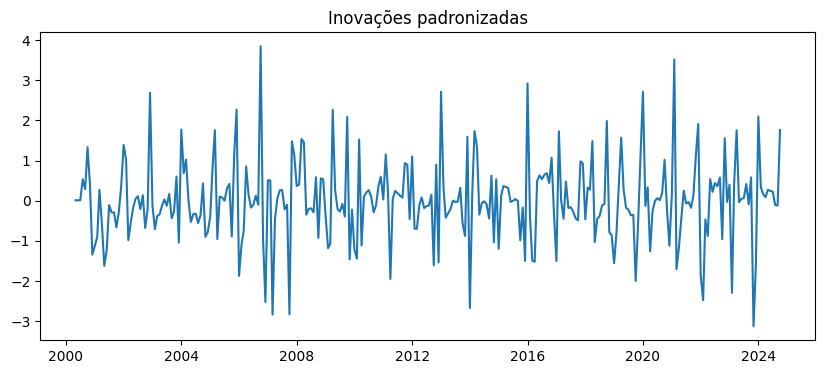

In [160]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(inovacoes)
ax.set_title('Inovações padronizadas')
plt.show()

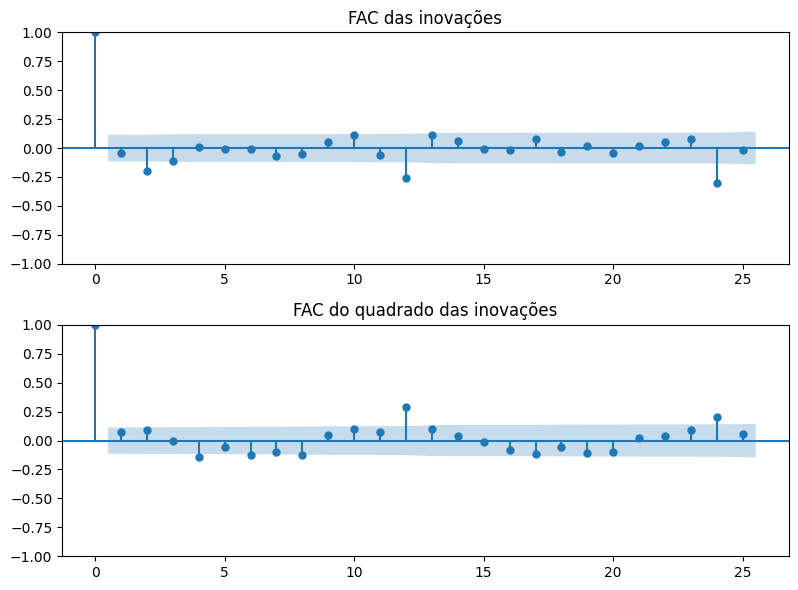

In [161]:
fig, ax = plt.subplots(2, figsize=(8,6))
plot_acf(inovacoes, ax=ax[0], title='FAC das inovações')
plot_acf(inovacoes.pow(2), ax=ax[1], title='FAC do quadrado das inovações')
fig.tight_layout()
plt.show()

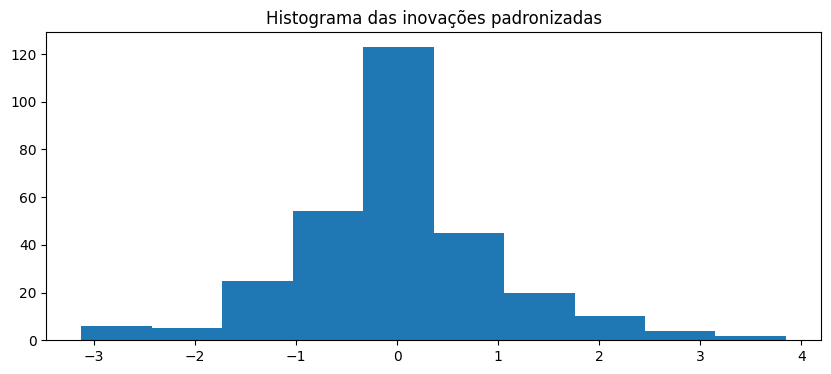

In [162]:
fig, ax = plt.subplots(figsize=(10,4))
ax.hist(inovacoes)
ax.set_title('Histograma das inovações padronizadas')
plt.show()

In [163]:
df_diagnostics = pd.DataFrame(columns=['Teste','Resultado'])

# coeficientes de assimetria e curtose
df_diagnostics.loc[df_diagnostics.shape[0]] = ['Assimetria', 'Coeficiente: {:.2f}'.format(inovacoes.skew())]
df_diagnostics.loc[df_diagnostics.shape[0]] = ['Curtose', 'Coeficiente: {:.2f}'.format(inovacoes.kurtosis()+3)]

# teste de jarque-bera
jb_result = jarque_bera(inovacoes)
df_diagnostics.loc[df_diagnostics.shape[0]] = ['Jarque-Bera', 'Estatística: {:.1f}, p-valor: {:.2f}'.format(jb_result[0], jb_result[1])]

# teste H
H_result = breakvar_heteroskedasticity_test(inovacoes, subset_length=1/3)
df_diagnostics.loc[df_diagnostics.shape[0]] = ['Teste H', 'Estatística: {:.1f}, p-valor: {:.2f}'.format(H_result[0], H_result[1])]

df_diagnostics.set_index('Teste')

,Resultado
Teste,
Assimetria,Coeficiente: 0.29
Curtose,Coeficiente: 4.86
Jarque-Bera,"Estatística: 43.9, p-valor: 0.00"
Teste H,"Estatística: 1.1, p-valor: 0.66"


## g) Gráfico das componentes

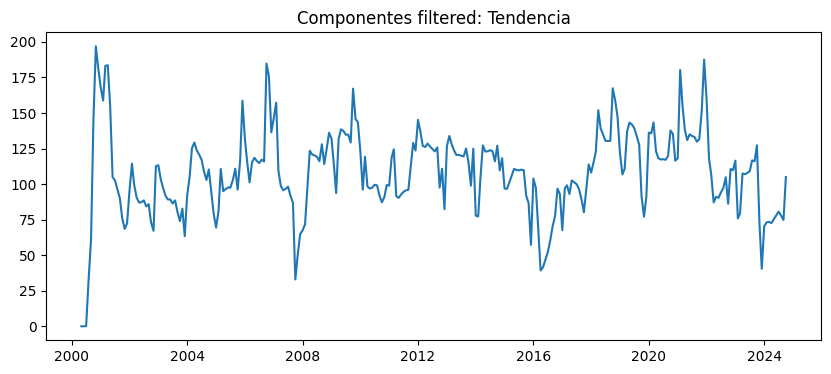

In [164]:
fig, ax = plt.subplots(figsize=(10,4))

mod = 'filtered'
var = 'tendencia'
ax.plot(resultados[mod][var])
ax.set_title('Componentes {}: {}'.format(mod, var.capitalize()))

# fig.suptitle('Precipitação total mensal por estação meteorológica do INMET (em mm)')
# fig.tight_layout()
plt.show()

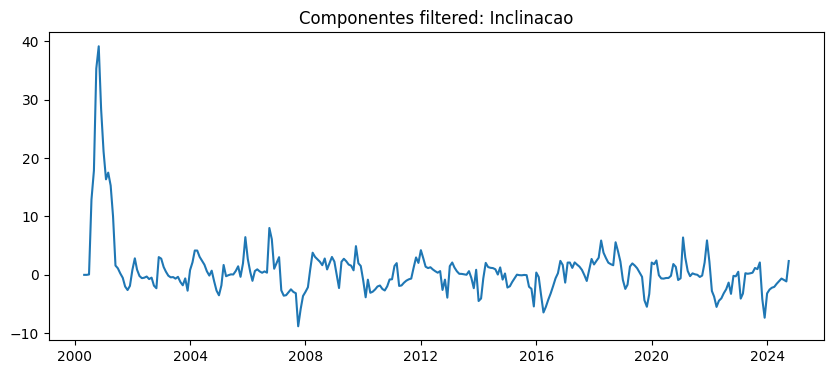

In [165]:
fig, ax = plt.subplots(figsize=(10,4))

mod = 'filtered'
var = 'inclinacao'
ax.plot(resultados[mod][var])
ax.set_title('Componentes {}: {}'.format(mod, var.capitalize()))

# fig.suptitle('Precipitação total mensal por estação meteorológica do INMET (em mm)')
# fig.tight_layout()
plt.show()